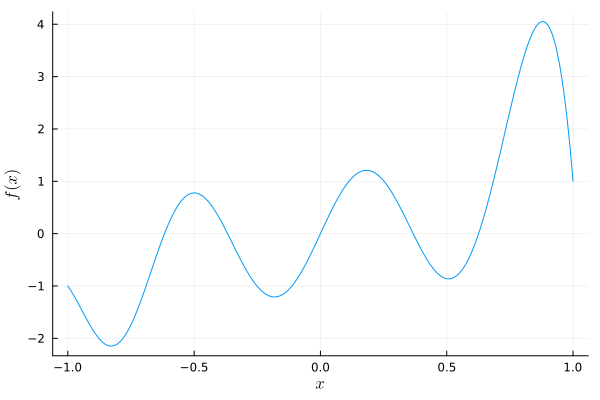

In [1]:
include("FourierChebyshev.jl")
using SpecialFunctions
f(x) = exp(erf(x^2)+x.^5).*sin(3*pi*x) + x
a = cheb(f)
plot_cheb(a)

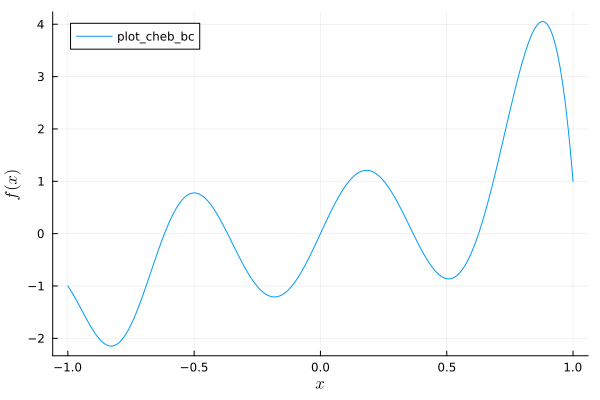

In [2]:
function plot_cheb_bc(ChebCoeffs_twosided;n=200,I=[-1,1],title="") # Input: Two-sided Chebyshev
    M = length(ChebCoeffs_twosided) # M: size of chebyshev
    a = I[1]; b = I[2]
    k = 0:M-1
    ξⱼ = chebpts(n)
    xc = (1.0 .- ξⱼ)*a/2 + (1.0 .+ ξⱼ)*b/2 # Chebyshev points in [a,b]
    fxc = cos.(Vector(k)' .* acos.(ξⱼ)) * ChebCoeffs_twosided
    # interpolation via barycentric formula
    ξ = range(-1,stop=1,length=5000)
    x = (1.0 .- ξ)*a/2 + (1.0 .+ ξ)*b/2
    λ = [1/2; ones(n-1); 1/2] .* (-1).^(0:n)

    numer = zeros(size(x))
    denom = zeros(size(x))
    exact = zeros(Bool,size(x))

    for j = 1:n+1
        xdiff = x .- xc[j]
        temp = λ[j] ./ xdiff
        numer += temp * fxc[j]
        denom += temp
        exact[xdiff.==0] .= true
    end

    fx = numer ./ denom
    jj = findall(exact)
    fx[jj] = f.(x[jj])
    plot(x, fx, label="plot_cheb_bc", title=title, xlabel="\$x\$",ylabel="\$f(x)\$")
end
plot_cheb_bc(a)

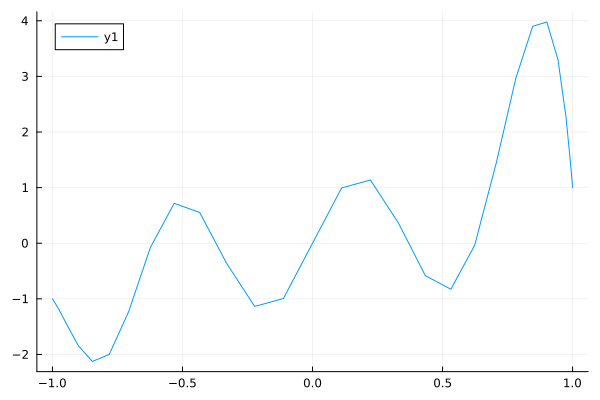

In [3]:
n = 28
xj = chebpts(n)
fj = f.(xj)
plot(xj,fj)

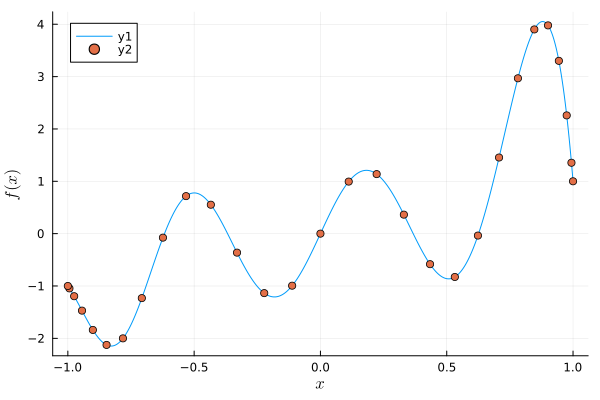

In [4]:
function plot_cheb_intp_bc(xc,fc;dom=[-1,1]) # Input: Two-sided Chebyshev
    a = dom[1]; b = dom[2]
    if length(xc)!=length(fc)
        display("error: length of the inputs must be same")
    end
    n = length(fc) - 1 # order of Chebyshev interpolation
    ξ = range(-1,stop=1,length=5000) # evaluation points in [-1,1]
    x = (1.0 .- ξ)*a/2 + (1.0 .+ ξ)*b/2 # evaluation points in [a,b]
    λ = [1/2; ones(n-1); 1/2] .* (-1).^(0:n) # barycentric weights

    numer = zeros(size(x))
    denom = zeros(size(x))
    exactx = zeros(Bool,size(x))
    exacty = zeros(Bool,size(fc))

    for j = 1:n+1
        xdiff = x .- xc[j]
        temp = λ[j] ./ xdiff
        numer += temp * fc[j]
        denom += temp
        if any(xdiff.==0)
            exactx[xdiff.==0] .= true
            exacty[j] = true
        end
    end

    fx = numer ./ denom
    jj = findall(exactx)
    j  = findall(exacty)
    fx[jj] = fc[j]
    plot(x, fx, xlabel="\$x\$",ylabel="\$f(x)\$")
end
plot_cheb_intp_bc(xj,fj)
scatter!(xj,fj)

In [5]:
function Chebdiffmat(d,p,n,dom)
    m = n - 1 #Chebyshev points
    m̄ = -m:2:m
    x = (sinpi.(m̄/(2*m)))
    if (dom[1]==-1 && dom[2]==1) #チェビシェフ節点を[-1,1]からdomへとスケーリング
    y=x
    else 
    y = dom[2]*(x .+ 1)/2 + dom[1]*(1 .- x)/2
    end
    # if ( dom[1] == -1 && dom[2] == 1 )
    #     return
    # end
    # w = (diff(dom)/2)*w;
    # end
    N=length(x)
    if d==0 #微分演算子Dを作成
        D=I(N)
    end
    if d>0
        ii = (1:N+1:N^2) #対角線のインデックス
        t = (m:-1:0).*pi/m　#t=acos(x)
        t = reverse(t)
        Dx = 2*(sin.((t .+ t')/2).*sin.((t .- t')/2))
        DxRot = rotl90(Dx, 2)
        idxTo=findall(rotl90(1 .-(UpperTriangular(ones(N,N)))).==1.0)
        Dx[idxTo] = -DxRot[idxTo]
        Dx[ii] .= 1
        Dxi = 1 ./Dx
    end
    w = [ones(N-1,1) ; .5]       # 重心補間式
    w[N-1:-2:1] .= -1
    w[1] = .5*w[1]
    if d>0
        Dw = w'./w
        Dw[ii] .= 0
        D = Dw .* Dxi
        D[ii] .= 0
        D[ii] = -sum(D,dims=2)
        D[ii[end:-1:N-floor(Int,N/2)+1]] = -D[ii[1:floor(Int,N/2)]]
    end
    if d>1
        D = 2*D .* (repeat(D[ii], 1, N) - Dxi )
        D[ii].=0
        D[ii] = -sum(D,dims=2) 
    end
    if d>2
        for q = 3:d 
        D = q*Dxi .* ( Dw.*repeat(D[ii], 1, N) - D )
        D[ii] .= 0
        D[ii] = -sum(D,dims=2)
        end
    end
    N=length(x)
    l=p-1
    l̄ = -l:2:l
    y = (sinpi.(l̄./(2*l)))
    M=length(y)
    w=reshape(w,1,N)
    s=acos.(y)
    r=acos.(x)
    B=2*(sin.((s .+ r')/2).*sin.((r' .- s)/2)) #ダウンサンプリング 
    #The purpose of this is that Y(j) - X(k) can be more accurately computed .
    #This is sometimes referred to as the 'trig trick' in spectralcollocation. 
    #'trig trick' that y-x = cos(s)-cos(r) = 2*sin((s+r)/2)*sin((r-s)/2)
    for k=1:N
        B[:,k] = w[k]./B[:,k]　#w(k)/(y(j)-x(k))
    end
    c = 1.0./sum(B, dims=2)　#正規化
    for j = 1:M
        B[j,:] = B[j,:]*c[j]
    end
    B[isnan.(B)].=1 #0で割られている要素が存在するから
    ii = rotl90(tril(ones(M, N)), 2)　#Flipping trick
    #the 'flipping trick' takes advantage of the fact that the smaller entries in R and S can b  computed more accurately. Note that X and Y should be symmetric about zero
# %   for this work, and it is assumed that S and R are sorted in descending
# %   order.
    ii = reverse(ii,dims=2)
    rot90D=rotl90(B,2)
    for i=1:1:p
        for j=1:1:(p-i)
            B[i,j]=rot90D[i,j]
        end
    end
    scl=(2/(dom[end]-dom[1]))^d　#スケーリング
    D=scl*D
    return B*D
end
function Chebdiffrow(n,d,v,dom)　
    m = n - 1 #Chebyshev points
    m̄ = -m:2:m
    x = (sinpi.(m̄./(2*m)))
    if (dom[1]==-1 && dom[2]==1)
        y=x
    else 
        y = dom[2]*(x .+ 1)/2 + dom[1]*(1 .- x)/2
    end
    N=length(x)
    w = [ones(N-1,1) ; .5]       # Note v(end) is positive.
    w[N-1:-2:1] .= -1
    w[1] = .5*w[1]
    t = (m:-1:0).*pi/m
    if d==0
        D=I(N)
    end
    if d>0
        ii = (1:N+1:N^2)
        t = (m:-1:0).*pi/m
        t = reverse(t)
        Dx = 2*(sin.((t .+ t')/2).*sin.((t .- t')/2))
        DxRot = rotl90(Dx, 2)
        idxTo=findall(rotl90(1 .-(UpperTriangular(ones(N,N)))).==1.0)
        Dx[idxTo] = -DxRot[idxTo]
        Dx[ii] .= 1
        Dxi = 1 ./Dx
    end
    if d>0
        Dw = w'./w
        Dw[ii] .= 0
        D = Dw .* Dxi
        D[ii] .= 0
        D[ii] = -sum(D,dims=2)
        D[ii[end:-1:N-floor(Int,N/2)+1]] = -D[ii[1:floor(Int,N/2)]]
    end
    if d>1
        D = 2*D .* (repeat(D[ii], 1, N) - Dxi )
        D[ii].=0
        D[ii] = -sum(D,dims=2) 
    end
    if d>2
        for q = 3:d 
        D = q*Dxi .* ( Dw.*repeat(D[ii], 1, N) - D )
        D[ii] .= 0
        D[ii] = -sum(D,dims=2)
        end
    end
    
    y = [-1,1]
    M=length(y)
    w=reshape(w,1,N)
    s=acos.(y)
    r=acos.(x)
    B=2*(sin.((s .+ r')/2).*sin.((r' .- s)/2))
    for k=1:N
        B[:,k] = w[k]./B[:,k]
    end
    c = 1.0./sum(B, dims=2)
    for j = 1:M
        B[j,:] = B[j,:]*c[j]
    end
    B[1,1]=1
    B[M,N]=1
    ii = rotl90(tril(ones(M, N)), 2)
    ii = reverse(ii,dims=2)
    rot90D=rotl90(B,2)
    D=B*D
    scl=(2/(dom[end]-dom[1]))^d
    D=scl*D
    if v==dom[1]
        r=D[1,:]
    elseif v==dom[2]
        r=D[end,:]
    else
        print(error)
    end
    return r
end
function Chebintrow(n,dom)
    a=dom[1]
    b=dom[2]
    m = n - 1 #Chebyshev points
    m̄ = -m:2:m
    x = (sinpi.(m̄./(2*m)))
    if (dom[1]==-1 && dom[2]==1)
    y=x
    else 
    y = dom[2]*(x .+ 1)/2 + dom[1]*(1 .- x)/2
    end
    c = 2.0./(1.0.-(0:2:(n-1)).^2) 
    c = (vcat(c,c[Int(floor(n/2)):-1:2]) )'
    w = ifft(c)             
    w[1] = w[1]/2
    w=hcat(w,w[1])
    return ((b-a)/2)*w
end
function Chebgridsample(y)
    diagm(y)
end

Chebgridsample (generic function with 1 method)

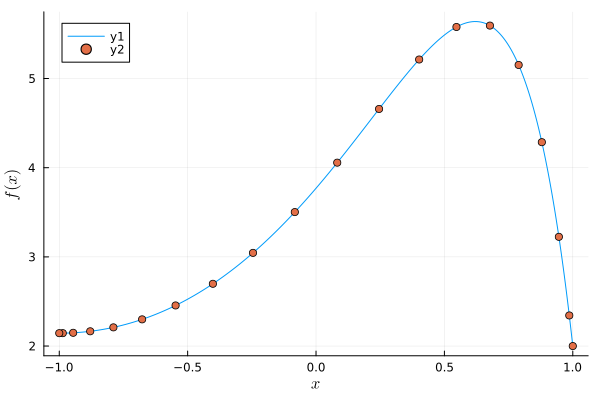

In [6]:
#Example1
using LinearAlgebra
f(x)=exp(x)
alpha=2
beta=0
n=18
dom=[-1 1]
L=0.2*Chebdiffmat(2,18,20,dom)+Chebdiffmat(1,18,20,dom)+Chebdiffmat(0,18,20,dom)
vT=Chebdiffrow(n+2,0,-1,dom)
wT=Chebdiffrow(n+2,1,1,dom)
A=[L;vT';wT']
m = n - 1 #Chebyshev points
m̄ = -m:2:m
x = (sinpi.(m̄./(2*m)))
f.(x)
rhs=[f.(x);alpha;beta]
u=A\rhs
xj = chebpts(length(u)-1)
plot_cheb_intp_bc(xj,u,dom=dom)
scatter!(xj,u)

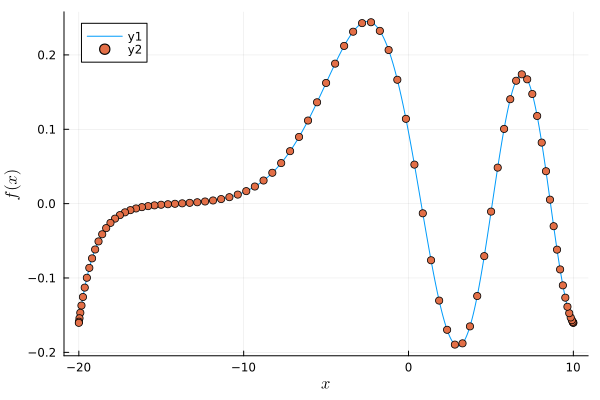

In [7]:
# example2 ２階の線形常微分方程式
using LinearAlgebra
a=-20
b=10
dom=[a b]
n=85
m = n - 1 #Chebyshev points
m̄ = -m:2:m
x = (sinpi.(m̄./(2*m)))
X=[a b]
L=Chebdiffmat(2,n,n+2,X)-Chebgridsample(x)*Chebdiffmat(0,n,n+2,X)
vT=Chebintrow(n+2,X)

wT=Chebdiffrow(n+2,0,b,X)-Chebdiffrow(n+2,0,a,X)
A=[L;vT;wT']

rhs=[zeros(n,1);1;0]
u=A\rhs
u=real(u)
# plot(u)
xj = chebpts(length(u)-1,a,b)
plot_cheb_intp_bc(xj,u,dom=dom)
scatter!(xj,u)